## **Elaborazione di Immagini Mediche**
### Laboratorio 4 - Region Growing




*   Collegamento a Google Drive e importare le librerie necessarie



In [117]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import skimage.io as img
import matplotlib.pyplot as plt
import numpy as np
import skimage
import plotly.express as px
from skimage.color import rgb2gray

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   Punto 1 (Lettura e visualizzazione immagine)

Dimensioni immagine: (512, 512)


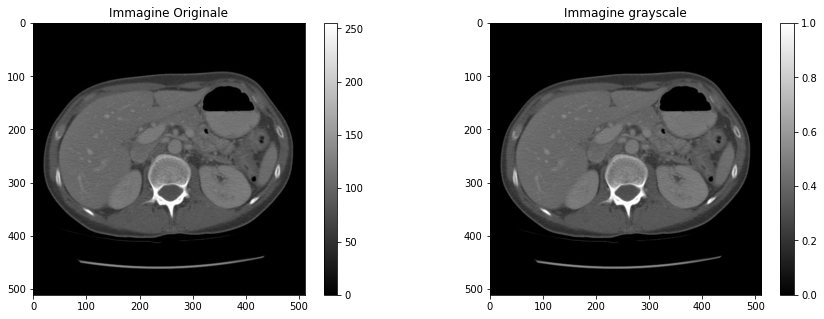

In [118]:
# Leggere l'immagine, trasformarla in grayscale (se necessario) e in formato float e visualizzarla

path = '/content/drive/MyDrive/EIM/lab4/'

filename = 'fegato.jpg'    
I = img.imread(path + filename)  # uint8
I_float = skimage.img_as_float(I)
I_gray = skimage.color.rgb2gray(I_float)

# Trovare il numero di righe e il numero di colonne dell'immagine
# %whos 
print(f"Dimensioni immagine: {I_gray.shape}")

# Visualizzare l'immagine (con colorbar)
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
z1_plot = ax1.imshow(I, cmap=plt.cm.gray)
fig.colorbar(z1_plot,ax=ax1)
ax1.set_title('Immagine Originale')
ax2 = plt.subplot(1, 2, 2)
z2_plot = ax2.imshow(I_gray, cmap=plt.cm.gray)
fig.colorbar(z2_plot,ax=ax2)
ax2.set_title('Immagine grayscale')

plt.show()

*   Punto 2 (Caricamento maschera manuale e applicazione maschera)

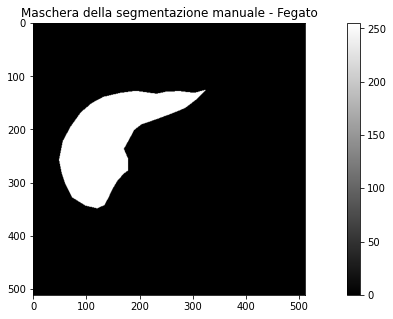

In [119]:
#Leggere l'immagine binaria che contiene la segmentazione manuale del fegato

filename = 'fegato_mask.png'    
mask = img.imread(path + filename)  # maschera in uint8

fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,1,1)
z1_plot = ax1.imshow(mask, cmap=plt.cm.gray)
fig.colorbar(z1_plot,ax=ax1)
ax1.set_title('Maschera della segmentazione manuale - Fegato')
 

# Trasformare in formato boolean
maskBool = np.array(mask, dtype=bool)
# Applicare la maschera sull'immagine
I_mask = I_gray*maskBool

*   Punto 3 (Determinazione valori per le soglie)

In [120]:
# Visualizzare l'immagine con px.imshow() - si consiglia di sfruttare lo zoom
fig = px.imshow(I_mask,color_continuous_scale='gray')
fig.show()


*   Punto 4 (Determinazione seeds e creazione maschera binaria)

In [121]:
# Definire le soglie Seed e Growing 
T1 = 0.5   #Valori di soglia per i seed iniziali 
T2 = 0.44    #Valore di soglia per la crescita 

# Trovare gli indici r e c dei pixel che superano la soglia T1 (np.where)
seeds_r, seeds_c = np.where(I_mask>=T1)    

# Inizializzare la maschera che conterrà i seeds (np.zeros - attenzione al formato!)
maskSeeds = np.zeros(I_mask.shape)

# Mettere i seeds pari a 1 nella maschera
maskSeeds[seeds_r, seeds_c] = 1

#Visualizzare la maschera iniziale
fig = px.imshow(maskSeeds,color_continuous_scale='gray')
fig.show()

*   Punto 5 (Inizializzazione vettore ToProcess e maschera di segmentazione)

In [122]:
# Inizializzare il vettore ToProcess che conterrà gli indici LINEARI dei pixel da analizzare (np.ravel_multi_index)
ToProcess = np.ravel_multi_index((seeds_r, seeds_c), maskSeeds.shape)

# Inizializzare la maschera che conterrà la segmentazione dei vasi
K2 = np.zeros(I_mask.shape)

*   Punto 6 (Scrittura funzione per trovare l'8 connesso)

In [123]:
# In ingresso le dimensioni dell’immagine e gli indici x e y del pixel considerato (attenzione ai bordi).
def conneigh8(x,y,shape):   # neigh8_x, neigh8_y = conneigh8(seeds_r,seeds_c,I.shape) 

  Nrows = shape[0]
  Ncols = shape[1]
  neigh8_x = np.array([], dtype = "uint8")
  neigh8_y = np.array([], dtype = "uint8")
  # Controllare i bordi
  for i in np.linspace(-1,1,3):
    for j in np.linspace(-1,1,3):
     if ((x+i)<Nrows and (x+i)>=0 and (y+j)<Ncols and (y+j)>=0):
       if (i== 0 and j==0):
         pass
       else:
        neigh8_x = np.append(neigh8_x, int(x+i))
        neigh8_y = np.append(neigh8_y, int(y+j))
  
  return neigh8_x, neigh8_y  #restituisce gli indici dell’insieme 8-connesso

# prova 
#nX, nY = conneigh8(0,0,[3,3])
#print(nX, nY)


*   Punto 7+8 (Implementazione Region Growing e visualizzazione segmentazione finale)

In [124]:
# REGION GROWING semplificata 
# Inserire la condizione di stop per l'algoritmo di region growing. L'algoritmo deve continuare 
# finché ci sono pixel da analizzare nel vettore ToProcess 

while (len(ToProcess)>0):

  # Isolare un pixel da analizzare nel vettore ToProcess (ad esempio il primo)
  current = ToProcess[-1]  # ultimo valore per ogni iterazione 
  
  # Ottenere gli indici r e c dall'indice lineare (np.unravel_index)
  current_r ,current_c = np.unravel_index(current,I_mask.shape)   # restituisce index_col e index_row

  # Aggiornare la maschera di segmentazione
  K2[current_r, current_c] = 1

  # Trovare l'8-connesso del pixel analizzato con la funzione conneigh8
  n8_x, n8_y = conneigh8(current_r,current_c,K2.shape)

  # Trovare quali elementi dell'8 connesso soddisfano le seguenti due condizioni:
  # - superano la soglia di crescita T2

  # - non sono ancora stati analizzati (i.e., i pixel sono ancora pari a 0 nella 
  #   maschera di segmentazione)
  n8r_T2, n8c_T2 = np.where((I_mask[n8_x,n8_y]>=T2) & (K2[n8_x,n8_y]==0), [n8_x, n8_y], -1)  

  n8c_T2=n8c_T2[np.where(n8c_T2!=-1)]
  n8r_T2=n8r_T2[np.where(n8r_T2!=-1)]

  # Trasformare gli indici r e c dei vicini trovati sopra in indici lineari (np.ravel_multi_index)
  n8 = np.ravel_multi_index([n8r_T2, n8c_T2], I_mask.shape)

  # Eliminare il pixel appena analizzato dal vettore ToProcess e concatenare in coda al vettore
  # ToProcess i vicini che soddisfano le condizioni
  ToProcess = np.delete(ToProcess, -1)   
  ToProcess = np.append(ToProcess, n8)

  # Rimuovere eventuali pixel doppioni nel vettore ToProcess (np.unique)
  ToProcess = np.unique(ToProcess)




In [125]:
# Creare l'immagine con la segmentazione finale dei vasi in bianco sull'immagine originale
I_seg_originale = I_gray + K2
I_seg_mask = I_mask + K2

# Visualizzare l'immagine ottenuta
fig = px.imshow(I_seg_originale,color_continuous_scale='gray')
fig.show()

fig = px.imshow(I_seg_mask,color_continuous_scale='gray')
fig.show()

Output hidden; open in https://colab.research.google.com to view.